#Chapter 9 - Machine Learning

see below for explanation 

https://www.fantasydatapros.com/fantasyfootball/course

In [1]:
%%capture
%pip install nfl-data-py

In [2]:
import nfl_data_py as nfl
import numpy as np
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from matplotlib import pyplot as plt

import warnings; warnings.simplefilter('ignore');

##Data Preprocessing

The goal is to get a row of data with a player's stats for a single season. We'll then use this row as input into a model that will predict the position of that player based on the season stats. Currently, the data is formatted into weekly data.

In [14]:
weekly_df = nfl.import_weekly_data(years=range(2000, 2022))
weekly_df.head()

Downcasting floats.


,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0000003,None,Abdul-Karim al-Jabbar,RB,RB,None,IND,2000,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,-0.2,-0.2
1,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,1,REG,...,0.0,-0.312120,0,0.0,0.045455,0.0,0.0,0.0,0.3,1.3
2,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,12,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.8,1.8
3,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,14,REG,...,1.0,0.609493,0,0.0,0.071429,0.0,0.0,0.0,4.9,5.9
4,00-0000007,None,Rabih Abdullah,RB,RB,None,TB,2000,15,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,1.4,1.4


In [15]:
weekly_df.columns

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'interceptions', 'sacks', 'sack_yards', 'sack_fumbles',
       'sack_fumbles_lost', 'passing_air_yards', 'passing_yards_after_catch',
       'passing_first_downs', 'passing_epa', 'passing_2pt_conversions', 'pacr',
       'dakota', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_fumbles',
       'rushing_fumbles_lost', 'rushing_first_downs', 'rushing_epa',
       'rushing_2pt_conversions', 'receptions', 'targets', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles', 'receiving_fumbles_lost',
       'receiving_air_yards', 'receiving_yards_after_catch',
       'receiving_first_downs', 'receiving_epa', 'receiving_2pt_conversions',
       'racr', 'target_share', 'air_yards_share', 'wopr', 'special_teams_tds',
       'fantasy_points', 'fantasy_point

We want to get this weekly stats data into season stats. 

Create some variables to help us group needed values and columns. 
Features will be the input columns for our model. Target is the output column  (the predicted column) from our model. 



In [45]:
eligible_positions = ['WR', 'RB', 'QB']
grouping_columns = ['player_id', 'season']
features = ['targets', 'receptions', 'rushing_yards', 'receiving_yards', 'passing_yards']
target = ['position']

Now - let's create the training df by filtering the weekly_df. 

We'll use a column index that is a concatenation of grouping_columns, features, target; and a row index of eligible_positions. This will give us the data from a row with position in eligible_positions, and then data from columns that are listed in the concatenation. 

In [46]:
train_df = weekly_df.loc[weekly_df['position'].isin(eligible_positions), grouping_columns + features + target]
train_df.head()

,player_id,season,targets,receptions,rushing_yards,receiving_yards,passing_yards,position
0,00-0000003,2000,0,0,-2.0,0.0,0.0,RB
1,00-0000007,2000,1,1,0.0,3.0,0.0,RB
2,00-0000007,2000,0,0,18.0,0.0,0.0,RB
3,00-0000007,2000,1,1,38.0,11.0,0.0,RB
4,00-0000007,2000,0,0,14.0,0.0,0.0,RB


In [47]:
train_df.shape

(86347, 8)

groupby_funcs is a dict that will be passed into agg() later. Here, we just want to make a dict with key position and value first. The 'first' value isn't a function or anything, it's just a string for now. But it could be something later.  

In [48]:
groupby_funcs = {
    'position': 'first'
}

groupby_funcs
# type(groupby_funcs['position'])

{'position': 'first'}

For loop - we're iterating over the groupby_funcs dict to append features. 

The first dict key:value pair is just position:first. That stays. Then we iterate using the features object. So we add/append each feature with each iteration of the for loop.

Now we have a dict with 6 pairs of key:value. 

1 with just key=position: value=first (str type)

5 with key=feature: value=a function that will sum that feature (function type)

In [49]:
for feature in features:
  groupby_funcs[feature] = np.sum

groupby_funcs
# type(groupby_funcs['position'])
# type(groupby_funcs['receiving_yards'])

{'position': 'first',
 'targets': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'receptions': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'rushing_yards': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'receiving_yards': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>,
 'passing_yards': <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>}

Now we edit the train_df. We groupby the grouping_columns, not using these as indexes. And we're aggregating the data using groupby_funcs dict we created. This is much quicker than aggregating each column after grouping by the grouping_columns. Using the groupby_funcs dict, we can group and aggregate much quicker. 

This results in a df with stats by season since the grouping columns were player_id and season. And we've also aggregated/summed all the 'features' - so that we now have season stats. 

Don't forget we have the target column - position - still.

In [50]:
train_df = train_df.groupby(grouping_columns, as_index=False).agg(groupby_funcs)
train_df.head()

,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards
0,00-0000003,2000,RB,0,0,-2.0,0.0,0.0
1,00-0000007,2000,RB,2,2,70.0,14.0,0.0
2,00-0000007,2001,RB,2,2,40.0,26.0,0.0
3,00-0000007,2003,RB,9,8,37.0,55.0,0.0
4,00-0000007,2004,RB,2,1,13.0,9.0,0.0


In [51]:
train_df.shape

(8950, 8)

Change categorical variables to numerical

In [52]:
train_df['position'].unique()

array(['RB', 'QB', 'WR'], dtype=object)

In [53]:
train_df['position'] = train_df['position'].replace({
    'RB':0,
    'WR':1,
    'QB':2
})

train_df.head()

,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards
0,00-0000003,2000,0,0,0,-2.0,0.0,0.0
1,00-0000007,2000,0,2,2,70.0,14.0,0.0
2,00-0000007,2001,0,2,2,40.0,26.0,0.0
3,00-0000007,2003,0,9,8,37.0,55.0,0.0
4,00-0000007,2004,0,2,1,13.0,9.0,0.0


In [54]:
train_df.shape

(8950, 8)

Filter players that haven't played much. Using boolean expressions (OR \\). 

In [64]:
train_df = train_df.loc[(train_df['rushing_yards']>200) | \
 (train_df['passing_yards']>300) | \
  (train_df['receiving_yards']>150)]

train_df.head()

,player_id,season,position,targets,receptions,rushing_yards,receiving_yards,passing_yards
5,00-0000104,2000,2,0,0,13.0,0.0,1616.0
6,00-0000145,2000,1,134,72,45.0,1265.0,0.0
7,00-0000145,2001,1,68,27,16.0,470.0,0.0
9,00-0000210,2000,0,60,39,1106.0,291.0,0.0
10,00-0000210,2001,0,45,31,476.0,212.0,0.0


In [65]:
train_df.shape

(5448, 8)

##Splitting data into training and testing

train_test_split() returns 4 values. We start by using unpacking notation to just name the output.

Then we list the input for the functions - the features, targets, test size, random state.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[features], #features
    train_df[target], #target
    test_size=0.2,
    random_state=123 #psuedorandom seed setting - allows us to replicate "randomness"
)

# X_train
# y_train
# y_test
train_df[features]

,targets,receptions,rushing_yards,receiving_yards,passing_yards
5,0,0,13.0,0.0,1616.0
6,134,72,45.0,1265.0,0.0
7,68,27,16.0,470.0,0.0
9,60,39,1106.0,291.0,0.0
10,45,31,476.0,212.0,0.0
...,...,...,...,...,...
8942,77,43,54.0,538.0,0.0
8944,49,33,6.0,353.0,0.0
8946,53,43,903.0,316.0,0.0
8948,0,0,168.0,0.0,603.0


In [37]:
train_df[features].shape
5448*0.8 #train size is 80% of train_df, test size is 20%

4358.400000000001

##Making the Decision Tree model

In [38]:
# Create the decision tree classifier
clf = DecisionTreeClassifier(max_depth=2) #setting a hyperparameter

# Fit the model to the training data; x=input(features), y=output(target)
clf.fit(X_train, y_train)
clf

DecisionTreeClassifier(max_depth=2)

In [39]:
# Predict the class labels for the testing data
#aka predict the results (the position label) using test data, not training
#training data used to make model, test data used to test model
#after testing, we can start to predict 
y_pred = clf.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

##Evaluate Model

In [40]:
# Evaluate the performance of the model - compare y_pred to the actual results (y_test)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.9825688073394495


##Vizualize plot tree
True is left, False is right
Value row shows the number of samples in each class_name. In our ex - all values add up to 44358 (samples n)

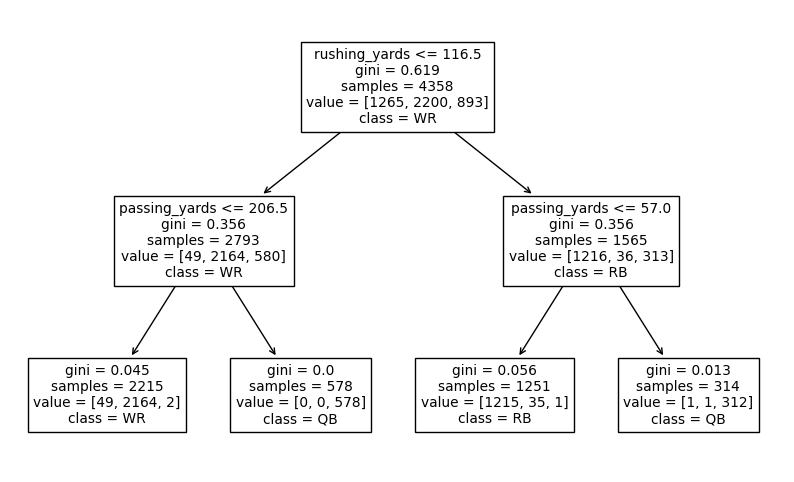

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))

class_names = ['RB', 'WR', 'QB']
plot_tree(clf, ax=ax, feature_names=features, class_names=class_names);

We see that <=116.5 rush yards, <=206.5 pass yards then we have a WR. If <=206.5 pass yards is FALSE, then we have a QB. 

##Hyperparameter Tuning 
Definitely review the hyperparameter tuning section again for this

https://www.fantasydatapros.com/fantasyfootball/course

min_samples_split is really the min number of samples that can be split - so if the number of samples going into a node is below one of these, the split won't happen. This helps overfitting.

In [66]:
# Specify the hyperparameters to optimize
params = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 6)}

clf = DecisionTreeClassifier()
#grid_search will do a pairwise search of best parameters for the clf model
#setting a cv (k-fold cross validation) value here is also a better way to determine the best split for training vs test data sets
grid_search = GridSearchCV(clf, params, cv=10)
grid_search.fit(train_df[features], train_df[target])

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 10),
                         'min_samples_split': range(2, 6)})

In [67]:
best_clf = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params

{'max_depth': 5, 'min_samples_split': 3}

In [68]:
 best_score

0.9823795871559634

In [69]:
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df
#RB=0, WR=1, QB=2

,precision,recall,f1-score,support
0,0.994135,0.954930,0.974138,355.000000
1,0.967557,0.996071,0.981607,509.000000
2,1.000000,0.995575,0.997783,226.000000
accuracy,0.982569,0.982569,0.982569,0.982569
macro avg,0.987231,0.982192,0.984509,1090.000000
weighted avg,0.982940,0.982569,0.982528,1090.000000


In [81]:
#support column = # samples
len(y_pred)
y_test['position'].value_counts()

1    509
0    355
2    226
Name: position, dtype: int64